# Supervised ML

The goal of this model is to predict the ridership that occurs within the University of Chicago Lyft Program Area. We will do this by using as features the ridership counts of other Chicago community areas, as well as using weather. The labels are the daily ridership counts within the program area.

We will create the model that functions up until the introduction of the University Lyft program and then look at the difference between the predictions and the actual ridership as a rough estimate of the effect of the program on rideshare usage in the area. We will do this by looking at both the change when the program was introduced, as well as when the program was reduced from 10 rides of up to 15 dollars each, to 7 rides up to 10 dollars. 

In [3]:
# read in packages create spark environment
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

import matplotlib.pyplot as plt
%matplotlib inline

spark = SparkSession.builder.appName('supervised').getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '4g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','4g')])

#print spark configuration settings
spark.sparkContext.getConf().getAll()

[('spark.stage.maxConsecutiveAttempts', '10'),
 ('spark.dynamicAllocation.minExecutors', '1'),
 ('spark.eventLog.enabled', 'true'),
 ('spark.submit.pyFiles',
  '/root/.ivy2/jars/com.johnsnowlabs.nlp_spark-nlp_2.12-4.4.0.jar,/root/.ivy2/jars/graphframes_graphframes-0.8.2-spark3.1-s_2.12.jar,/root/.ivy2/jars/com.typesafe_config-1.4.2.jar,/root/.ivy2/jars/org.rocksdb_rocksdbjni-6.29.5.jar,/root/.ivy2/jars/com.amazonaws_aws-java-sdk-bundle-1.11.828.jar,/root/.ivy2/jars/com.github.universal-automata_liblevenshtein-3.0.0.jar,/root/.ivy2/jars/com.google.cloud_google-cloud-storage-2.16.0.jar,/root/.ivy2/jars/com.navigamez_greex-1.0.jar,/root/.ivy2/jars/com.johnsnowlabs.nlp_tensorflow-cpu_2.12-0.4.4.jar,/root/.ivy2/jars/it.unimi.dsi_fastutil-7.0.12.jar,/root/.ivy2/jars/org.projectlombok_lombok-1.16.8.jar,/root/.ivy2/jars/com.google.guava_guava-31.1-jre.jar,/root/.ivy2/jars/com.google.guava_failureaccess-1.0.1.jar,/root/.ivy2/jars/com.google.guava_listenablefuture-9999.0-empty-to-avoid-conflict-

### Reading in cleaned data, partitioning

In [2]:
# read in rideshare data for all years, concatenate, create appropriate partitioning
# we are dropping 2020 because covid will affect the performance of our model

df_2018 = spark.read.csv("gs://msca-bdp-student-gcs/bdp-rideshare-project/rideshare/processed_data/rides_2018.csv", inferSchema=True, header=True)
df_2019 = spark.read.csv("gs://msca-bdp-student-gcs/bdp-rideshare-project/rideshare/processed_data/rides_2019.csv", inferSchema=True, header=True)
df_2021 = spark.read.csv("gs://msca-bdp-student-gcs/bdp-rideshare-project/rideshare/processed_data/rides_2021.csv", inferSchema=True, header=True)
df_2022 = spark.read.csv("gs://msca-bdp-student-gcs/bdp-rideshare-project/rideshare/processed_data/rides_2022.csv", inferSchema=True, header=True)
df_2023 = spark.read.csv("gs://msca-bdp-student-gcs/bdp-rideshare-project/rideshare/processed_data/rides_2023.csv", inferSchema=True, header=True)

# dropping new columns in 2023
df_2023 = df_2023.drop('Shared Trip Match','Percent Time Chicago','Percent Distance Chicago')

df_all = df_2018.union(df_2019).union(df_2021).union(df_2022).union(df_2023)
df_all.show(5)

+--------------------+-------------------+-------------------+-------+-----+------------+-------------+-----------+------------+----+---+-----+-------------+--------------+-------------+--------------+-----+------------+----+---+
|                  ID|    start_timestamp|      end_timestamp|seconds|miles|pickup_tract|dropoff_tract|pickup_area|dropoff_area|Fare|Tip|total|   pickup_lat|    pickup_lon|  dropoff_lat|   dropoff_lon|month|day_of_month|hour|day|
+--------------------+-------------------+-------------------+-------+-----+------------+-------------+-----------+------------+----+---+-----+-------------+--------------+-------------+--------------+-----+------------+----+---+
|625e77ae6e0ff7191...|2018-11-06 19:00:00|2018-11-06 19:15:00|   1142|  5.8| 17031063400|  17031010400|          6|           1|12.5|  0| 15.0|41.9346591566|-87.6467297286| 42.004764559| -87.659122427|   11|           6|  19|  3|
|62945fdb2e70957f0...|2018-11-06 19:00:00|2018-11-06 19:00:00|    341|  1.2| 170

In [5]:
#display number of records by partition
def displaypartitions(df):
    #number of records by partition
    num = df.rdd.getNumPartitions()
    print("Partitions:", num)
    df.withColumn("partitionId", F.spark_partition_id())\
        .groupBy("partitionId")\
        .count()\
        .orderBy(F.asc("count"))\
        .show(num)

df_all.rdd.getNumPartitions()
displaypartitions(df_all)


Partitions: 544


+-----------+------+
|partitionId| count|
+-----------+------+
|         42|305254|
|         41|305316|
|         40|305420|
|         38|305471|
|         39|305480|
|         37|305618|
|         36|305676|
|         35|305871|
|         34|305890|
|         33|305962|
|         32|305971|
|         31|306010|
|         29|306031|
|         30|306038|
|         28|306086|
|         27|306127|
|         26|306402|
|         25|306467|
|         24|306633|
|         23|306731|
|         22|307226|
|        243|328837|
|        242|328975|
|        241|329131|
|        240|329163|
|        239|329209|
|        237|329245|
|        235|329263|
|        238|329263|
|        234|329311|
|        236|329315|
|        232|329332|
|        233|329344|
|        231|329373|
|        228|329389|
|        229|329390|
|        227|329399|
|        226|329410|
|        225|329410|
|        224|329418|
|        230|329427|
|        223|329428|
|        220|329461|
|        222|329481|
|        221|

In [3]:
# repartitioning to 600 partitions, seems to be balanced now. 
df_all = df_all.repartition(600)
#displaypartitions(df_all)

In [4]:
# we will need a year column in this model
df_all = df_all.withColumn('year', F.year(df_all.start_timestamp))

In [8]:
df_all.printSchema()

root
 |-- ID: string (nullable = true)
 |-- start_timestamp: timestamp (nullable = true)
 |-- end_timestamp: timestamp (nullable = true)
 |-- seconds: integer (nullable = true)
 |-- miles: double (nullable = true)
 |-- pickup_tract: long (nullable = true)
 |-- dropoff_tract: long (nullable = true)
 |-- pickup_area: integer (nullable = true)
 |-- dropoff_area: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Tip: integer (nullable = true)
 |-- total: double (nullable = true)
 |-- pickup_lat: double (nullable = true)
 |-- pickup_lon: double (nullable = true)
 |-- dropoff_lat: double (nullable = true)
 |-- dropoff_lon: string (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- year: integer (nullable = true)



In [5]:
# take a sample to test these operations out on first
#sample_df = df_all.sample(fraction=1/1000000)

# get only the columns needed for the model
selected_columns = ["pickup_area","dropoff_area","day","month","year","ID"]
selected_df = df_all.select(selected_columns)

**Daily counts for each community area**

we had to group by pickup area and dropoff area seperately- daily counts of number of trips to that particular community area when it was either a pickup or dropoff area

In [6]:
# Calculate daily counts for pickup areas
pickup_counts = selected_df.groupby('day', 'month', 'year', 'pickup_area').count().withColumnRenamed('count', 'pickup_count')
pickup_counts = pickup_counts.withColumnRenamed('pickup_area', 'area')

In [7]:
# Calculate daily counts for dropoff areas
dropoff_counts = selected_df.groupby('day', 'month', 'year', 'dropoff_area').count().withColumnRenamed('count', 'dropoff_count')
dropoff_counts = dropoff_counts.withColumnRenamed('dropoff_area', 'area')

In [8]:
pickup_counts = pickup_counts.withColumn('dropoff_count', F.lit(0))
dropoff_counts = dropoff_counts.withColumn('pickup_count', F.lit(0))

# ensuring same column order
pickup_counts = pickup_counts.select('day', 'month', 'year', 'area', 'pickup_count', 'dropoff_count')
dropoff_counts = dropoff_counts.select('day', 'month', 'year', 'area', 'pickup_count', 'dropoff_count')

# Union the pickup and dropoff dataframes
combined_df = pickup_counts.union(dropoff_counts)

# Group by day, month, year, and area, summing up the counts
daily_counts_by_area = combined_df.groupby('day', 'month', 'year', 'area').sum('pickup_count', 'dropoff_count')

# the relatively smaller numbers are mostly a result of the sample size, should be fine when we 
# make it to the entire dataframe
daily_counts_by_area = daily_counts_by_area.withColumn('total_counts', F.col('sum(pickup_count)') + F.col('sum(dropoff_count)'))
daily_counts_by_area.drop('sum(pickup_count)','sum(dropoff_count)')
daily_counts_by_area.show(10)

+---+-----+----+----+-----------------+------------------+------------+
|day|month|year|area|sum(pickup_count)|sum(dropoff_count)|total_counts|
+---+-----+----+----+-----------------+------------------+------------+
|  6|    7|2022|   8|           167867|            172693|      340560|
|  4|    8|2022|   6|            40523|             39734|       80257|
|  7|   11|2022|  42|             7351|              7392|       14743|
|  7|   12|2022|  76|            18491|             29572|       48063|
|  6|    1|2022|  76|            13224|             18168|       31392|
|  7|   11|2022|  73|             2196|              2170|        4366|
|  2|    1|2022|   1|             6929|              7019|       13948|
|  4|    8|2022|  56|             9706|             11844|       21550|
|  1|   12|2022|   5|             7162|              7406|       14568|
|  5|    4|2022|   1|             7085|              6183|       13268|
+---+-----+----+----+-----------------+------------------+------

Pivoting the dataset for community areas

In [9]:
#keep datetime as part of the pivot. 

# pivot so that each community area is a column
# one row for each day, each column represents a community area (with its entry being daily count of rides for that area).

# Pivot the DataFrame
pivoted_df = daily_counts_by_area.groupBy("day", "month", "year").pivot("area").sum("total_counts")

# Show the results
pivoted_df.show()

23/11/25 23:32:49 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---+-----+----+-----+-----+-----+-----+-----+------+------+------+----+----+----+----+----+-----+-----+-----+----+----+-----+----+-----+-----+-----+------+-----+----+-----+------+-----+-----+-----+------+-----+-----+-----+----+----+-----+-----+----+-----+-----+-----+-----+----+----+----+----+-----+----+----+----+----+----+---+-----+----+----+----+-----+----+----+----+----+----+-----+----+-----+-----+----+-----+----+----+----+----+-----+-----+
|day|month|year|    1|    2|    3|    4|    5|     6|     7|     8|   9|  10|  11|  12|  13|   14|   15|   16|  17|  18|   19|  20|   21|   22|   23|    24|   25|  26|   27|    28|   29|   30|   31|    32|   33|   34|   35|  36|  37|   38|   39|  40|   41|   42|   43|   44|  45|  46|  47|  48|   49|  50|  51|  52|  53|  54| 55|   56|  57|  58|  59|   60|  61|  62|  63|  64|  65|   66|  67|   68|   69|  70|   71|  72|  73|  74|  75|   76|   77|
+---+-----+----+-----+-----+-----+-----+-----+------+------+------+----+----+----+----+----+-----+-----+

Read in weather data, merge with rideshare data

In [10]:
df_weather_1 = spark.read.csv("gs://msca-bdp-student-gcs/bdp-rideshare-project/weather/chicago 2018-01-01 to 2020-01-01.csv", inferSchema=True, header=True)
df_weather_2 = spark.read.csv("gs://msca-bdp-student-gcs/bdp-rideshare-project/weather/chicago 2020-01-01 to 2022-08-31.csv", inferSchema=True, header=True)
df_weather_3 = spark.read.csv("gs://msca-bdp-student-gcs/bdp-rideshare-project/weather/chicago 2022-09-01 to 2022-12-31.csv", inferSchema=True, header=True)
df_weather_4 = spark.read.csv("gs://msca-bdp-student-gcs/bdp-rideshare-project/weather/chicago 2023-01-01 to 2023-11-22.csv", inferSchema=True, header=True)
df_weather = df_weather_1.union(df_weather_2).union(df_weather_3).union(df_weather_4)

In [11]:
df_weather = df_weather.select('name', 'datetime', 'temp','precip','snow','snowdepth','sunset')
df_weather = df_weather.withColumn('sunset', F.concat(F.hour(df_weather.sunset),F.minute(df_weather.sunset)))
df_weather.printSchema()
pivoted_df.printSchema()
# name, datetime, temp, precip, snow, snowdepth, sunset.
# merge on datetime- keep datetime as part of the pivot. 

root
 |-- name: string (nullable = true)
 |-- datetime: string (nullable = true)
 |-- temp: double (nullable = true)
 |-- precip: double (nullable = true)
 |-- snow: double (nullable = true)
 |-- snowdepth: double (nullable = true)
 |-- sunset: string (nullable = true)

root
 |-- day: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- 1: long (nullable = true)
 |-- 2: long (nullable = true)
 |-- 3: long (nullable = true)
 |-- 4: long (nullable = true)
 |-- 5: long (nullable = true)
 |-- 6: long (nullable = true)
 |-- 7: long (nullable = true)
 |-- 8: long (nullable = true)
 |-- 9: long (nullable = true)
 |-- 10: long (nullable = true)
 |-- 11: long (nullable = true)
 |-- 12: long (nullable = true)
 |-- 13: long (nullable = true)
 |-- 14: long (nullable = true)
 |-- 15: long (nullable = true)
 |-- 16: long (nullable = true)
 |-- 17: long (nullable = true)
 |-- 18: long (nullable = true)
 |-- 19: long (nullable = true)
 |-- 20: long 

In [52]:
df_weather.show(2)

+-------+----------+----+------+----+---------+------+
|   name|  datetime|temp|precip|snow|snowdepth|sunset|
+-------+----------+----+------+----+---------+------+
|chicago|2018-01-01|-2.7|   0.0| 0.0|      0.6|  1630|
|chicago|2018-01-02|-0.7|   0.0| 0.0|      0.3|  1631|
+-------+----------+----+------+----+---------+------+
only showing top 2 rows



In [12]:
from pyspark.sql.functions import concat_ws, to_date, lpad

# pad the days and months with zeros for converting to datetime
padded_month = lpad(pivoted_df["month"], 2, "0")
padded_day = lpad(pivoted_df["day"], 2, "0")

# concatenate columns and create datetime column for merging
date_string_column = concat_ws("-", pivoted_df["year"], padded_month, padded_day)
pivoted_df = pivoted_df.withColumn('datetime',F.to_date(date_string_column,'yyy-MM-dd'))
pivoted_df.show(2)

+---+-----+----+-----+----+-----+-----+-----+-----+-----+------+---+----+----+----+----+----+----+-----+----+----+----+----+-----+-----+-----+-----+-----+----+----+-----+----+----+-----+------+-----+----+----+----+---+----+----+----+-----+----+-----+----+----+----+---+----+----+----+----+---+----+---+---+-----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+----+-----+-----+----------+
|day|month|year|    1|   2|    3|    4|    5|    6|    7|     8|  9|  10|  11|  12|  13|  14|  15|   16|  17|  18|  19|  20|   21|   22|   23|   24|   25|  26|  27|   28|  29|  30|   31|    32|   33|  34|  35|  36| 37|  38|  39|  40|   41|  42|   43|  44|  45|  46| 47|  48|  49|  50|  51| 52|  53| 54| 55|   56|  57|  58|  59|  60|  61|  62|  63|  64|  65|  66|  67|  68|  69|  70|  71|  72|  73| 74|  75|   76|   77|  datetime|
+---+-----+----+-----+----+-----+-----+-----+-----+-----+------+---+----+----+----+----+----+----+-----+----+----+----+----+-----+-----+----

In [13]:
# create the program area sum column
pivoted_df = pivoted_df.withColumn('area_sums', pivoted_df['39'] + pivoted_df['41'] + pivoted_df['42'])
pivoted_df.show(2)

+---+-----+----+-----+----+-----+-----+-----+-----+-----+------+---+----+----+----+----+----+----+-----+----+----+----+----+-----+-----+-----+-----+-----+----+----+-----+----+----+-----+------+-----+----+----+----+---+----+----+----+-----+----+-----+----+----+----+---+----+----+----+----+---+----+---+---+-----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+----+-----+-----+----------+---------+
|day|month|year|    1|   2|    3|    4|    5|    6|    7|     8|  9|  10|  11|  12|  13|  14|  15|   16|  17|  18|  19|  20|   21|   22|   23|   24|   25|  26|  27|   28|  29|  30|   31|    32|   33|  34|  35|  36| 37|  38|  39|  40|   41|  42|   43|  44|  45|  46| 47|  48|  49|  50|  51| 52|  53| 54| 55|   56|  57|  58|  59|  60|  61|  62|  63|  64|  65|  66|  67|  68|  69|  70|  71|  72|  73| 74|  75|   76|   77|  datetime|area_sums|
+---+-----+----+-----+----+-----+-----+-----+-----+-----+------+---+----+----+----+----+----+----+-----+----+----+----+-

In [14]:
# Drop day and the community areas that were summed earlier, will use year and month in regression
pivoted_df = pivoted_df.drop('day','39','41','42')

df_weather = df_weather.withColumn('datetime', F.to_date('datetime', 'yyyy-MM-dd'))

# Perform the left join with weather data
merged_df = pivoted_df.join(df_weather, on='datetime', how='left')
merged_df.show(2)

+----------+-----+----+-----+----+-----+-----+-----+-----+-----+------+---+----+----+----+----+----+----+-----+----+----+----+----+-----+-----+-----+-----+-----+----+----+-----+----+----+-----+------+-----+----+----+----+---+----+----+-----+----+----+----+---+----+----+----+----+---+----+---+---+-----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+----+-----+-----+---------+-------+----+------+----+---------+------+
|  datetime|month|year|    1|   2|    3|    4|    5|    6|    7|     8|  9|  10|  11|  12|  13|  14|  15|   16|  17|  18|  19|  20|   21|   22|   23|   24|   25|  26|  27|   28|  29|  30|   31|    32|   33|  34|  35|  36| 37|  38|  40|   43|  44|  45|  46| 47|  48|  49|  50|  51| 52|  53| 54| 55|   56|  57|  58|  59|  60|  61|  62|  63|  64|  65|  66|  67|  68|  69|  70|  71|  72|  73| 74|  75|   76|   77|area_sums|   name|temp|precip|snow|snowdepth|sunset|
+----------+-----+----+-----+----+-----+-----+-----+-----+-----+------+---+-

In [15]:
merged_df = merged_df.drop('datetime','name') #since no longer needed. 
merged_df.show(2)

+-----+----+-----+----+-----+-----+-----+-----+-----+------+---+----+----+----+----+----+----+-----+----+----+----+----+-----+-----+-----+-----+-----+----+----+-----+----+----+-----+------+-----+----+----+----+---+----+----+-----+----+----+----+---+----+----+----+----+---+----+---+---+-----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+----+-----+-----+---------+----+------+----+---------+------+
|month|year|    1|   2|    3|    4|    5|    6|    7|     8|  9|  10|  11|  12|  13|  14|  15|   16|  17|  18|  19|  20|   21|   22|   23|   24|   25|  26|  27|   28|  29|  30|   31|    32|   33|  34|  35|  36| 37|  38|  40|   43|  44|  45|  46| 47|  48|  49|  50|  51| 52|  53| 54| 55|   56|  57|  58|  59|  60|  61|  62|  63|  64|  65|  66|  67|  68|  69|  70|  71|  72|  73| 74|  75|   76|   77|area_sums|temp|precip|snow|snowdepth|sunset|
+-----+----+-----+----+-----+-----+-----+-----+-----+------+---+----+----+----+----+----+----+-----+----+----+----

In [16]:
# write completed data to a GCS bucket so we don't have to rerun things
merged_df.write.option("header", "true").csv("gs://msca-bdp-student-gcs/bdp-rideshare-project/rideshare/processed_data/supervised_dataset_final.csv")

# ML Model

1. Create Datasets that are for data pre-program (Oct 2021) and for data between Oct 2021 up to not including july 2023.
2. Get Cross Validated Model Running
3. Train model on first dataset. predict for october, november, december 2021
4. plot predictions (dotted line for predictions, solid line for actual)
5. train new model on second dataset
6. plot for july, 


In [4]:
# skip all the above and just run this line to get the final dataset loaded in to use with the ML model
merged_df = spark.read.csv("gs://msca-bdp-student-gcs/bdp-rideshare-project/rideshare/processed_data/supervised_dataset_final.csv", inferSchema=True, header=True)

In [5]:
# this is the data for predicting the first policy change
df_1 = merged_df.filter((merged_df.year < 2021) | ((merged_df.year == 2021) & (merged_df.month < 10))) 
# this is the data for predicting the second policy change
df_2 = merged_df.filter(((merged_df.year == 2021) & (merged_df.month >= 10)) | (merged_df.year == 2022) | ((merged_df.year == 2023) & (merged_df.month < 7)))
# this is the data after the second policy change
df_3 = merged_df.filter(((merged_df.year == 2023) & (merged_df.month >= 7)))

## I'm trying to organize my thoughts about prediction here, hopefully this makes some sense.

The way we've been thinking about this model is that it is predicting daily counts, so our predictions should be daily as well.
So I think I should take the rows from df2 that are in 10,11,12 and make predictions for each one. put those in a dataframe. Group by month and summ predicted rides.
Then take the actual sums from df2, group by month and sum. Plot those against each other

I'm going to work on doing this without cross validation first, and then move to cross validation depending on time.

In [11]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import StringIndexer,OneHotEncoder, IndexToString, VectorAssembler
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import FloatType
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel

In [7]:
# make sure sunset is an integer so it works in the model
df_1 = df_1.withColumn("sunset", F.col("sunset").cast("int"))

In [8]:
df_2 = df_2.withColumn("sunset", F.col("sunset").cast("int"))
df_3 = df_3.withColumn("sunset", F.col("sunset").cast("int"))

## Impact of Program on rides in Hyde Park

This model will be for predicting the first policy change using df_1

#### Building model to predict rides in program area based on pre-program data

Using df1 (all pre-program data) to predict what would happen to count of rides if the program had not happened at all.

In [26]:
# input features are everythin but the area_sums column which is what we are trying to predict
input_features = ['month','year','1','2','3','4','5','6','7','8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20','21','22','23','24','25',
 '26','27','28','29','30','31','32','33','34','35','36','37','38','40','43','44','45','46','47','48','49','50','51','52','53','54','55','56','57','58','59','60','61','62','63','64','65','66',
 '67','68','69','70','71','72','73','74','75','76','77','temp','precip','snow','snowdepth','sunset']

# adding the handleInvalid = 'skip' allows this to run- double check what it is doing
vectorAssembler = VectorAssembler(inputCols=input_features,
                                  outputCol="features", handleInvalid='skip')

# splitting first and then doing vector assembly to avoid errors
train_df, test_df = df_1.randomSplit([.7,.3],seed=1234)

train_df = vectorAssembler.transform(train_df)
test_df = vectorAssembler.transform(test_df)

In [27]:
train_df = train_df.na.drop()  # Remove rows with null values

# Train Model
from pyspark.ml.regression import LinearRegression

#Elastic Net
lr = LinearRegression(featuresCol = 'features', labelCol='area_sums', regParam=0.3, elasticNetParam=0.8, maxIter=10)
lrm = lr.fit(train_df)

#coefficients
print("Coefficients: " + str(lrm.coefficients))
print("Intercept: " + str(lrm.intercept))

#model summary
print("RMSE: %f" % lrm.summary.rootMeanSquaredError)
print("r2: %f" % lrm.summary.r2)

# Run the classifier on the test set
predictions = lrm.transform(test_df)
predictions.select('features','area_sums','prediction').show(5,truncate=False)

23/11/26 00:20:31 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/11/26 00:20:31 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


Coefficients: [-141.17821491897232,-745.3452416033055,0.04069589047839324,0.10523630495219816,0.002416215491090195,0.025009680242684473,0.015991560747858,-0.000809268481126041,-0.0003083326046310907,0.001719524462734702,-0.34154509015643614,-0.08238655427681342,-0.0,-0.0,0.779895783342685,0.05086694893622908,0.025653865341783114,0.024961895150708617,0.19582968856485264,0.2782530128506548,0.05452784089546298,0.17385879886338018,0.0187564547338862,0.003440291549253111,0.050322500767793425,0.0028592082630942497,-0.025445117595504444,0.0,0.14513263303240942,0.010301942556421948,0.02382458946533733,0.13529300450184567,0.0461338629846489,0.009441369903795505,0.01915890689447327,0.030501308888032312,0.16639747544742067,0.372961105529036,1.0630578240307724,0.15210946145832405,0.3574990068792217,-0.009678684217525414,0.05007541974459699,0.3291731701458939,-0.13681731725138238,1.8145586373952591,0.17587067975956647,0.10694274072585269,1.1307091745949909,-0.32397755445680976,0.7275761869829841,0.

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+------------------+
|features                                                                                                                                                                                                                                                                                                                                                                   

In [29]:
#print evaluation metrics
e = RegressionEvaluator(labelCol='area_sums', predictionCol= 'prediction', metricName= 'rmse')

# Root Mean Square Error
rmse = e.evaluate(predictions)
print("RMSE: %.3f" % rmse)

# Mean Square Error
mse = e.evaluate(predictions, {e.metricName: "mse"})
print("MSE: %.3f" % mse)

# Mean Absolute Error
mae = e.evaluate(predictions, {e.metricName: "mae"})
print("MAE: %.3f" % mae)

# r2 - coefficient of determination
r2 = e.evaluate(predictions, {e.metricName: "r2"})
print("r2: %.3f" %r2)

RMSE: 4090.238


MSE: 16730047.318


MAE: 3102.571


r2: 0.950


In [30]:
# save model
model_path = "gs://msca-bdp-student-gcs/bdp-rideshare-project/models/pre_program_model"
lrm.save(model_path)

### Pre-program trends and predictions

Pre-program ride trends- what would the ridership be in the program areas for 2018 - Sept 2021 based on the model- predict for area_sums against actual area_sums before the program started (pre-trends).

In [105]:
# load pre-program model
from pyspark.ml.regression import LinearRegressionModel
from pyspark.ml.feature import VectorAssembler

# Path to saved model on GCS
model_path = "gs://msca-bdp-student-gcs/bdp-rideshare-project/models/pre_program_model"

# Load the Linear Regression Model
lrm = LinearRegressionModel.load(model_path)

# dataframe that is the true counts
df_real = df_1

# input features are everything but the area_sums column which is what we are trying to predict
input_features = ['month','year','1','2','3','4','5','6','7','8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20','21','22','23','24','25',
 '26','27','28','29','30','31','32','33','34','35','36','37','38','40','43','44','45','46','47','48','49','50','51','52','53','54','55','56','57','58','59','60','61','62','63','64','65','66',
 '67','68','69','70','71','72','73','74','75','76','77','temp','precip','snow','snowdepth','sunset']

# adding the handleInvalid = 'skip' allows this to run- double check what it is doing
vectorAssembler = VectorAssembler(inputCols=input_features, outputCol="features", handleInvalid='skip')

# take the real data and create predictions to compare
df_real_vector = vectorAssembler.transform(df_real)
df_pre_program_predictions = lrm.transform(df_real_vector)

df_pre_program_predictions.show(2)
df_real.show(2)

+-----+----+-----+-----+-----+-----+-----+------+------+------+----+----+----+----+----+-----+-----+-----+----+----+-----+----+-----+------+-----+------+-----+----+----+------+-----+-----+-----+------+-----+-----+-----+----+----+-----+----+-----+-----+----+----+---+----+----+----+----+----+----+---+---+-----+----+----+----+-----+-----+----+----+----+----+----+----+----+-----+----+-----+----+----+----+----+-----+-----+---------+----+------+----+---------+------+--------------------+------------------+
|month|year|    1|    2|    3|    4|    5|     6|     7|     8|   9|  10|  11|  12|  13|   14|   15|   16|  17|  18|   19|  20|   21|    22|   23|    24|   25|  26|  27|    28|   29|   30|   31|    32|   33|   34|   35|  36|  37|   38|  40|   43|   44|  45|  46| 47|  48|  49|  50|  51|  52|  53| 54| 55|   56|  57|  58|  59|   60|   61|  62|  63|  64|  65|  66|  67|  68|   69|  70|   71|  72|  73|  74|  75|   76|   77|area_sums|temp|precip|snow|snowdepth|sunset|            features|        

In [106]:
# now group by month and sum counts and plot

#df_real.withColumn("month", F.format_string("%02d", df_real.month.cast("int")))
#df_real.select('month').show(5)
monthly_real = df_real.withColumn("year_month", F.concat_ws("-", df_real.year, df_real.month))
df_pre_program_predictions = df_pre_program_predictions.withColumn("year_month", F.concat_ws("-", df_pre_program_predictions.year, df_pre_program_predictions.month))

#monthly_real.select('year_month').distinct().show(30)
monthly_real = monthly_real.groupBy('year_month').sum('area_sums')
monthly_pre_program_preds = df_pre_program_predictions.groupby('year_month').sum('prediction')

In [107]:
monthly_real_pd = monthly_real.toPandas()
monthly_pre_program_preds_pd = monthly_pre_program_preds.toPandas()
combined_df = monthly_real_pd.merge(monthly_pre_program_preds_pd, left_on='year_month', right_on='year_month', how='inner')
combined_df

,year_month,sum(area_sums),sum(prediction)
0,2019-10,435438,418766.823378
1,2019-4,458738,437424.914776
2,2019-11,428752,411241.410744
3,2021-3,178045,193006.695556
4,2021-4,176680,178816.816038
5,2019-9,351479,395490.044955
6,2019-2,452100,419238.609782
7,2019-5,456471,446927.511582
8,2019-6,422260,417559.979058
9,2021-5,183403,177115.769091


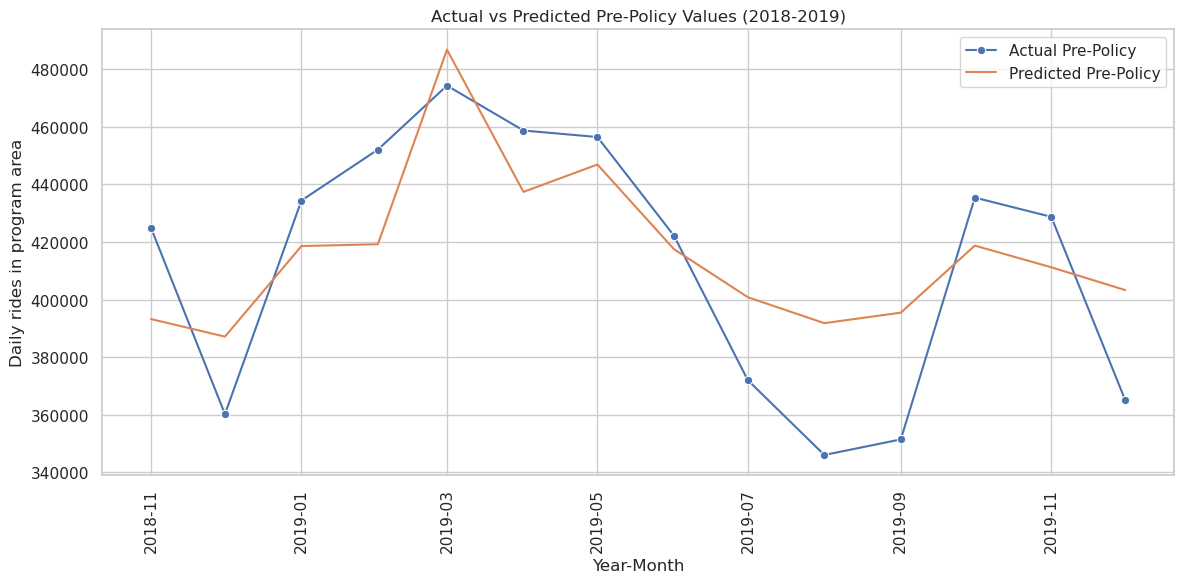

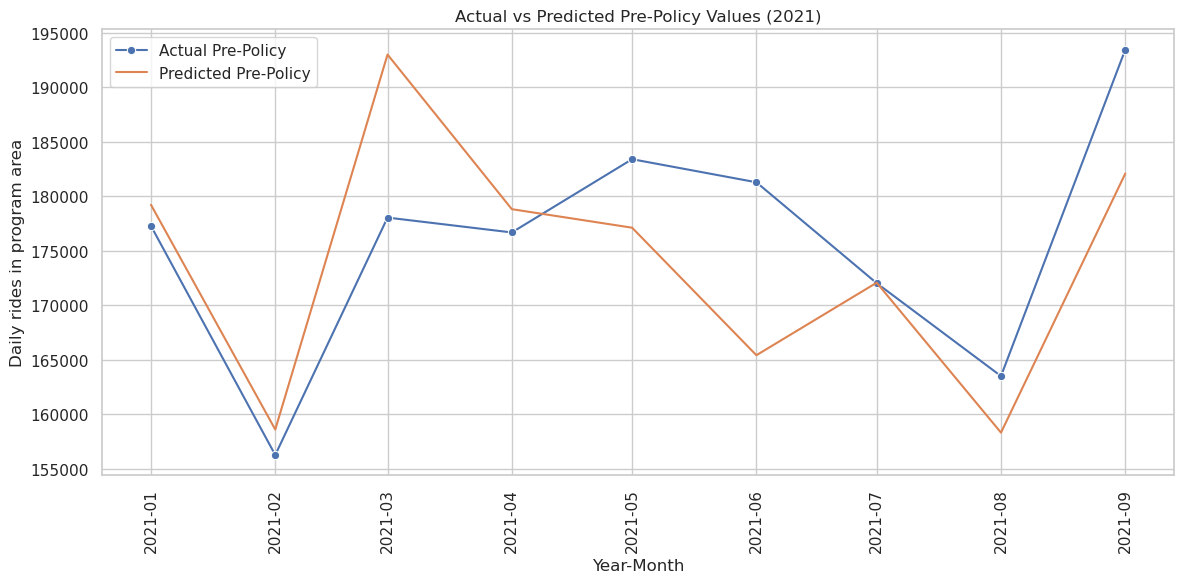

In [79]:
combined_df['year_month'] = pd.to_datetime(combined_df['year_month'], format='%Y-%m')

# Filter the DataFrame to exclude the year 2020
df_2018_2019 = combined_df[(combined_df['year_month'].dt.year >= 2018) & (combined_df['year_month'].dt.year <= 2019)]
df_2021 = combined_df[combined_df['year_month'].dt.year == 2021]

# Plot for 2018-2019
plt.figure(figsize=(12, 6))
sns.lineplot(x='year_month', y='sum(area_sums)', data=df_2018_2019, marker='o', label='Actual Pre-Policy')
sns.lineplot(x='year_month', y='sum(prediction)', data=df_2018_2019, dashes=True, label='Predicted Pre-Policy')
plt.title('Actual vs Predicted Pre-Policy Daily Rides (2018-2019)')
plt.xlabel('Year-Month')
plt.ylabel('Daily rides in program area')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

# Plot for 2021
plt.figure(figsize=(12, 6))
sns.lineplot(x='year_month', y='sum(area_sums)', data=df_2021, marker='o', label='Actual Pre-Policy')
sns.lineplot(x='year_month', y='sum(prediction)', data=df_2021, dashes=True, label='Predicted Pre-Policy')
plt.title('Actual vs Predicted Pre-Policy Daily Rides (2021)')
plt.xlabel('Year-Month')
plt.ylabel('Daily rides in program area')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

In [109]:
# joining different datasets together
final_dataset = df_2021 


#### Program starts- assessing initial Impact

Using the trained model for predicting count of rides in program area if program had not started for the period of Oct 2021- Dec 2021 when in program rides were only on weekends. 

In [110]:
# dataframe that is the true counts
# only Oct, Nov, Dec of 2021. 
df_real = df_2.filter(df_2.year == 2021)

# take the real data and create predictions to compare
df_real_vector = vectorAssembler.transform(df_real)
df_first_predictions = lrm.transform(df_real_vector)

df_first_predictions.show(2)
df_real.show(2)

+-----+----+-----+-----+-----+-----+-----+------+------+------+----+----+----+----+----+-----+-----+-----+----+----+-----+----+-----+-----+-----+------+-----+----+----+------+----+----+-----+------+-----+-----+----+----+----+----+----+-----+-----+----+----+---+----+----+----+----+---+----+----+---+-----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+----+-----+-----+---------+----+------+----+---------+------+--------------------+------------------+
|month|year|    1|    2|    3|    4|    5|     6|     7|     8|   9|  10|  11|  12|  13|   14|   15|   16|  17|  18|   19|  20|   21|   22|   23|    24|   25|  26|  27|    28|  29|  30|   31|    32|   33|   34|  35|  36|  37|  38|  40|   43|   44|  45|  46| 47|  48|  49|  50|  51| 52|  53|  54| 55|   56|  57|  58|  59|  60|  61|  62|  63|  64|  65|  66|  67|  68|  69|  70|  71|  72|  73| 74|  75|   76|   77|area_sums|temp|precip|snow|snowdepth|sunset|            features|        prediction|
+-----+-

In [117]:
monthly_real = df_real.withColumn("year_month", F.concat_ws("-", df_real.year, df_real.month))
df_first_predictions = df_first_predictions.withColumn("year_month", F.concat_ws("-", df_first_predictions.year, df_first_predictions.month))

#monthly_real.select('year_month').distinct().show(30)
monthly_real = monthly_real.groupBy('year_month').sum('area_sums')
monthly_first_preds = df_first_predictions.groupby('year_month').sum('prediction')

In [118]:
monthly_real_pd = monthly_real.toPandas()
monthly_first_preds_pd = monthly_first_preds.toPandas()
combined_df = monthly_real_pd.merge(monthly_first_preds_pd, left_on='year_month', right_on='year_month', how='inner')
combined_df

,year_month,sum(area_sums),sum(prediction)
0,2021-11,275975,201316.311757
1,2021-10,265236,210299.350589
2,2021-12,258103,207578.423603


Add stuff to make this graph much prettier- title, axis's etc. 

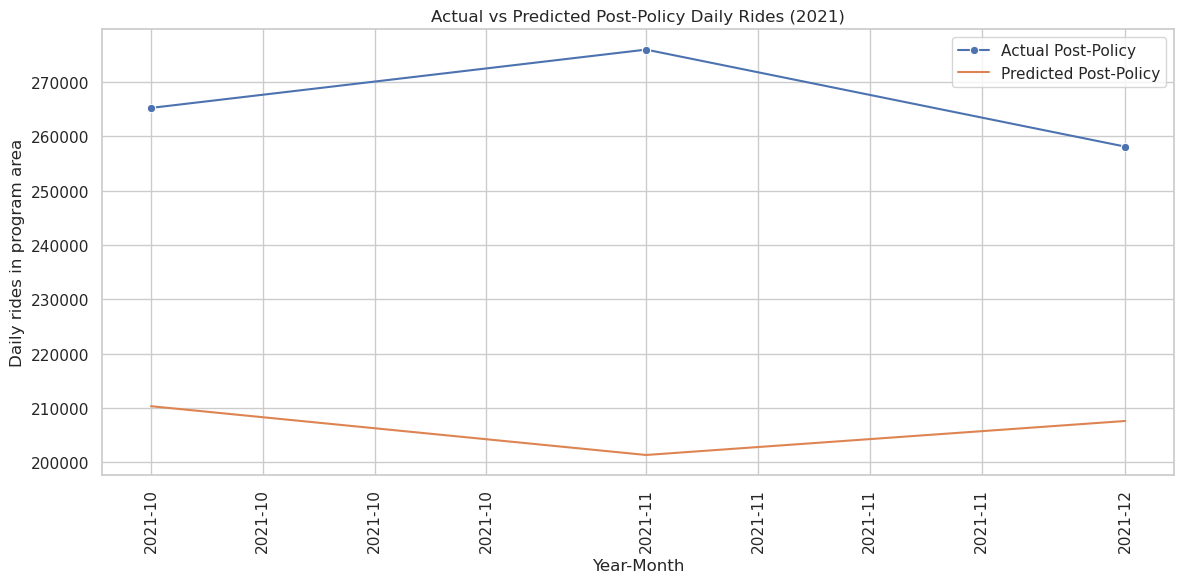

In [119]:
combined_df['year_month'] = pd.to_datetime(combined_df['year_month'], format='%Y-%m')

# Plot for 2021
plt.figure(figsize=(12, 6))
sns.lineplot(x='year_month', y='sum(area_sums)', data=combined_df, marker='o', label='Actual Post-Policy')
sns.lineplot(x='year_month', y='sum(prediction)', data=combined_df, dashes=True, label='Predicted Post-Policy')
plt.title('Actual vs Predicted Post-Policy Daily Rides (2021)')
plt.xlabel('Year-Month')
plt.ylabel('Daily rides in program area')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

In [122]:
final_dataset = pd.concat([final_dataset, combined_df], ignore_index=True)
final_dataset

,year_month,sum(area_sums),sum(prediction)
0,2021-03-01,178045,193006.695556
1,2021-04-01,176680,178816.816038
2,2021-05-01,183403,177115.769091
3,2021-09-01,193462,182082.974058
4,2021-08-01,163498,158309.023479
5,2021-06-01,181285,165413.667248
6,2021-02-01,156257,158592.509085
7,2021-07-01,172026,172070.713297
8,2021-01-01,177280,179217.039411
9,2021-11-01,275975,201316.311757


#### Impact of policy expansion:to all days (5pm-4am), 10 rides a month

Use the same model (of pre-program rides) to predict for the entirety of df2 (between Oct 2021- June 2023) when the policy was expanded. 

In [123]:
# load pre-program model
from pyspark.ml.regression import LinearRegressionModel
from pyspark.ml.feature import VectorAssembler

# Path to saved model on GCS
model_path = "gs://msca-bdp-student-gcs/bdp-rideshare-project/models/pre_program_model"

# Load the Linear Regression Model
lrm = LinearRegressionModel.load(model_path)

# filter to get entirety of time when program was expanded
# dataframe that is the true counts
# time period after 2021
df_real = df_2.filter(df_2.year != 2021)

# input features are everything but the area_sums column which is what we are trying to predict
input_features = ['month','year','1','2','3','4','5','6','7','8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20','21','22','23','24','25',
 '26','27','28','29','30','31','32','33','34','35','36','37','38','40','43','44','45','46','47','48','49','50','51','52','53','54','55','56','57','58','59','60','61','62','63','64','65','66',
 '67','68','69','70','71','72','73','74','75','76','77','temp','precip','snow','snowdepth','sunset']

# adding the handleInvalid = 'skip' allows this to run- double check what it is doing
vectorAssembler = VectorAssembler(inputCols=input_features, outputCol="features", handleInvalid='skip')

# take the real data and create predictions to compare
df_real_vector = vectorAssembler.transform(df_real)
df_second_predictions = lrm.transform(df_real_vector)

df_second_predictions.show(2)
df_real.show(2)


+-----+----+-----+-----+-----+-----+-----+-----+-----+------+---+----+----+----+----+----+----+-----+----+----+-----+----+-----+-----+-----+-----+-----+----+----+------+-----+----+-----+------+-----+----+----+----+----+----+----+-----+-----+----+----+---+----+----+----+----+---+----+----+---+-----+----+----+----+----+----+----+----+----+----+----+----+----+-----+----+-----+----+----+---+----+-----+-----+---------+----+------+----+---------+------+--------------------+------------------+
|month|year|    1|    2|    3|    4|    5|    6|    7|     8|  9|  10|  11|  12|  13|  14|  15|   16|  17|  18|   19|  20|   21|   22|   23|   24|   25|  26|  27|    28|   29|  30|   31|    32|   33|  34|  35|  36|  37|  38|  40|   43|   44|  45|  46| 47|  48|  49|  50|  51| 52|  53|  54| 55|   56|  57|  58|  59|  60|  61|  62|  63|  64|  65|  66|  67|  68|   69|  70|   71|  72|  73| 74|  75|   76|   77|area_sums|temp|precip|snow|snowdepth|sunset|            features|        prediction|
+-----+----+----

In [124]:
# now group by month and sum counts and plot

#df_real.withColumn("month", F.format_string("%02d", df_real.month.cast("int")))
#df_real.select('month').show(5)
monthly_real = df_real.withColumn("year_month", F.concat_ws("-", df_real.year, df_real.month))
monthly_second_preds = df_second_predictions.withColumn("year_month", F.concat_ws("-", df_second_predictions.year, df_second_predictions.month))

#monthly_real.select('year_month').distinct().show(30)
monthly_real = monthly_real.groupBy('year_month').sum('area_sums')
monthly_second_preds = monthly_second_preds.groupby('year_month').sum('prediction')

In [125]:
monthly_real_pd = monthly_real.toPandas()
monthly_second_preds_pd = monthly_second_preds.toPandas()
combined_df = monthly_real_pd.merge(monthly_second_preds_pd, left_on='year_month', right_on='year_month', how='inner')
combined_df

,year_month,sum(area_sums),sum(prediction)
0,2023-1,461079,263854.436567
1,2022-4,365044,229855.316322
2,2023-4,463392,280383.624732
3,2023-5,469985,291879.252644
4,2022-7,273441,238003.298985
5,2022-11,403456,243251.328962
6,2022-5,365878,237826.757514
7,2022-10,439440,262934.652192
8,2022-9,310420,231850.364094
9,2022-1,274172,210230.981548


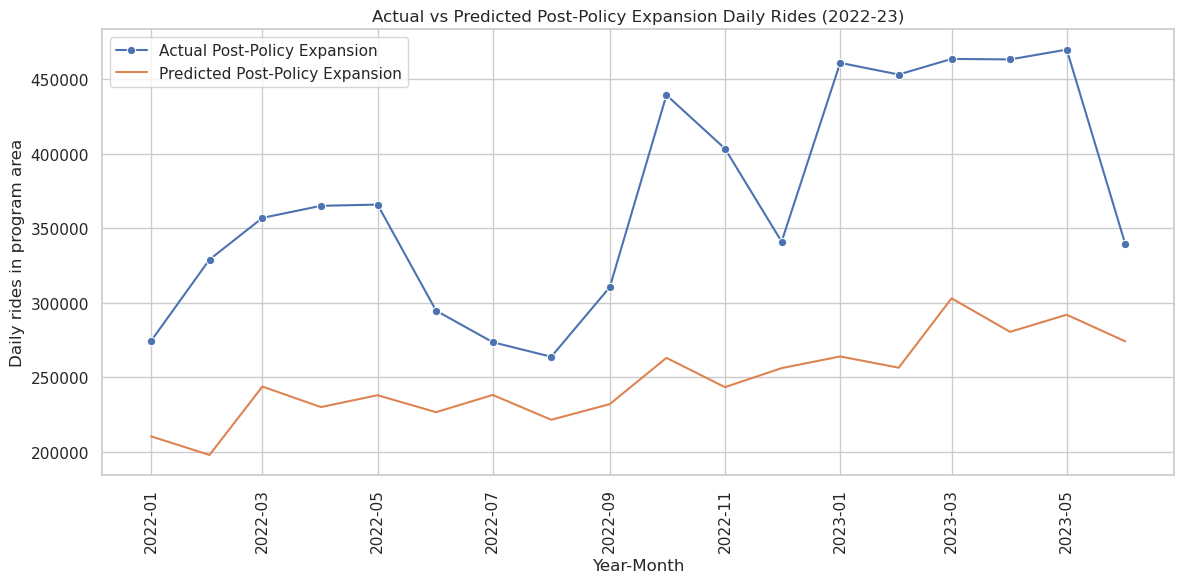

In [126]:
combined_df['year_month'] = pd.to_datetime(combined_df['year_month'], format='%Y-%m')

# Plot for 2018-2019
plt.figure(figsize=(12, 6))
sns.lineplot(x='year_month', y='sum(area_sums)', data=combined_df, marker='o', label='Actual Post-Policy Expansion')
sns.lineplot(x='year_month', y='sum(prediction)', data=combined_df, dashes=True, label='Predicted Post-Policy Expansion')
plt.title('Actual vs Predicted Post-Policy Expansion Daily Rides (2022-23)')
plt.xlabel('Year-Month')
plt.ylabel('Daily rides in program area')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

In [127]:
final_dataset = pd.concat([final_dataset, combined_df], ignore_index=True)
final_dataset

,year_month,sum(area_sums),sum(prediction)
0,2021-03-01,178045,193006.695556
1,2021-04-01,176680,178816.816038
2,2021-05-01,183403,177115.769091
3,2021-09-01,193462,182082.974058
4,2021-08-01,163498,158309.023479
5,2021-06-01,181285,165413.667248
6,2021-02-01,156257,158592.509085
7,2021-07-01,172026,172070.713297
8,2021-01-01,177280,179217.039411
9,2021-11-01,275975,201316.311757


### Program reduction - assessing impact
Predicting when policy changed to 7 rides days, 10 dollars a month. 

Creating another model based on in-program real data from df_2. 

In [50]:
# adding the handleInvalid = 'skip' allows this to run- double check what it is doing
vectorAssembler = VectorAssembler(inputCols=input_features,
                                  outputCol="features", handleInvalid='skip')

# splitting first and then doing vector assembly to avoid errors
train_df, test_df = df_2.randomSplit([.7,.3],seed=1234)

train_df = vectorAssembler.transform(train_df)
test_df = vectorAssembler.transform(test_df)

In [51]:
train_df = train_df.na.drop()  # Remove rows with null values

# Train Model
from pyspark.ml.regression import LinearRegression

#Elastic Net
lr = LinearRegression(featuresCol = 'features', labelCol='area_sums', regParam=0.3, elasticNetParam=0.8, maxIter=10)
lrm = lr.fit(train_df)

#coefficients
print("Coefficients: " + str(lrm.coefficients))
print("Intercept: " + str(lrm.intercept))

#model summary
print("RMSE: %f" % lrm.summary.rootMeanSquaredError)
print("r2: %f" % lrm.summary.r2)

# Run the classifier on the test set
predictions = lrm.transform(test_df)
predictions.select('features','area_sums','prediction').show(5,truncate=False)

Coefficients: [-217.34093676028456,1578.480812555171,0.5537942505135528,0.062080882287470274,0.03118791057209453,0.0746681159031738,0.036376208836090634,-0.0013722080654734968,0.0031201423180575566,-0.0014115479528669977,-0.49732250406216444,-0.13616525364015059,0.410592256809017,-0.9702291764676397,1.6554338324869962,0.13647510986857794,0.14239425694967234,0.07276673041681377,0.07688233314150066,0.5481713121277239,0.07727026195361791,0.2571312316898789,0.07029743643850779,0.014518759690937135,0.07243090130519246,0.0026475035032199976,0.07445054051041215,0.33409007019994763,0.21356579199400424,0.010553094784998544,-0.016908040264507998,0.13391110120468358,0.07456021110309917,-0.0035608334233764786,-0.006186040779805305,-0.03033246856426237,-0.5088825212553649,-1.8384196499638998,1.3896041569375672,-0.0,0.31416388620658353,0.13970873112685042,0.16015505985305448,-0.11223977048607371,0.3920010021748861,1.2457638390022423,-0.08761068454762237,0.19243817040700043,0.3077046392950376,0.50804

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+-----------------+
|features                                                                                                                                                                                                                                                                                                                                                                                         

In [52]:
#print evaluation metrics
e = RegressionEvaluator(labelCol='area_sums', predictionCol= 'prediction', metricName= 'rmse')

# Root Mean Square Error
rmse = e.evaluate(predictions)
print("RMSE: %.3f" % rmse)

# Mean Square Error
mse = e.evaluate(predictions, {e.metricName: "mse"})
print("MSE: %.3f" % mse)

# Mean Absolute Error
mae = e.evaluate(predictions, {e.metricName: "mae"})
print("MAE: %.3f" % mae)

# r2 - coefficient of determination
r2 = e.evaluate(predictions, {e.metricName: "r2"})
print("r2: %.3f" %r2)

RMSE: 5874.389


MSE: 34508445.347


MAE: 4927.196


r2: 0.851


In [ ]:
# save model
model_path = "gs://msca-bdp-student-gcs/bdp-rideshare-project/models/program_reduction_model"
lrm.save(model_path)

In [129]:
# load pre-program model
from pyspark.ml.regression import LinearRegressionModel
from pyspark.ml.feature import VectorAssembler

# Path to saved model on GCS
model_path = "gs://msca-bdp-student-gcs/bdp-rideshare-project/models/program_reduction_model"

# Load the Linear Regression Model
lrm = LinearRegressionModel.load(model_path)

# dataframe that is the true counts
df_real = df_3

# take the real data and create predictions to compare
df_real_vector = vectorAssembler.transform(df_real)
df_second_predictions = lrm.transform(df_real_vector)

monthly_real = df_real.withColumn("year_month", F.concat_ws("-", df_real.year, df_real.month))
df_second_predictions = df_second_predictions.withColumn("year_month", F.concat_ws("-", df_second_predictions.year, df_second_predictions.month))

#monthly_real.select('year_month').distinct().show(30)
monthly_real = monthly_real.groupBy('year_month').sum('area_sums')
monthly_second_preds = df_second_predictions.groupby('year_month').sum('prediction')


monthly_real_pd = monthly_real.toPandas()
monthly_second_preds_pd = monthly_second_preds.toPandas()
combined_df = monthly_real_pd.merge(monthly_second_preds_pd, left_on='year_month', right_on='year_month', how='inner')
combined_df

,year_month,sum(area_sums),sum(prediction)
0,2023-9,228913,262678.673214
1,2023-8,6681,6186.443012
2,2023-7,10666,36928.352373


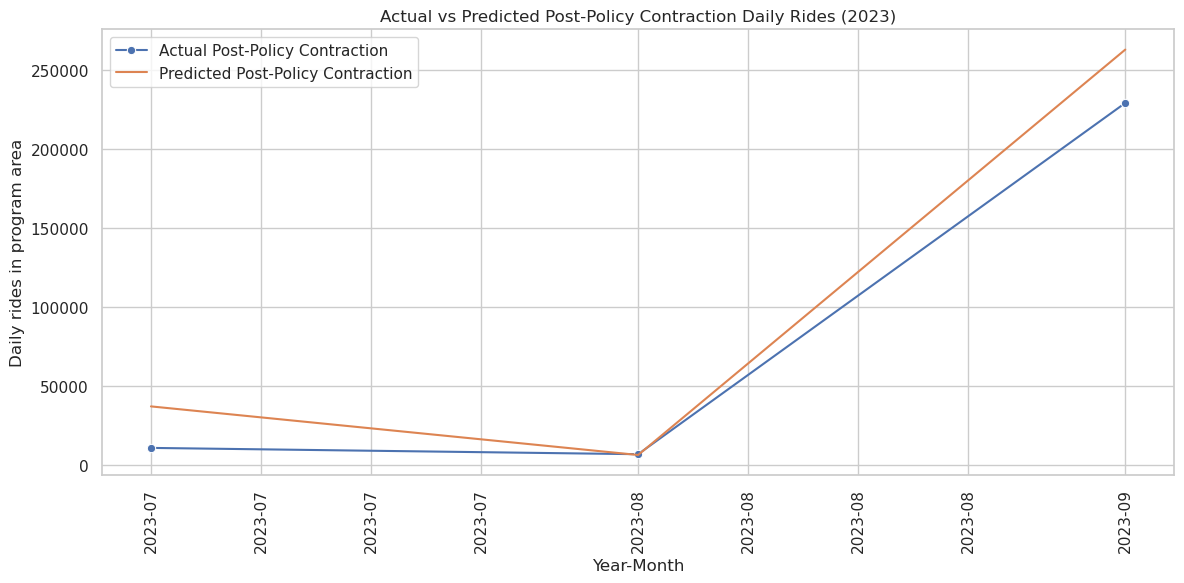

In [130]:
combined_df['year_month'] = pd.to_datetime(combined_df['year_month'], format='%Y-%m')

plt.figure(figsize=(12, 6))
sns.lineplot(x='year_month', y='sum(area_sums)', data=combined_df, marker='o', label='Actual Post-Policy Contraction')
sns.lineplot(x='year_month', y='sum(prediction)', data=combined_df, dashes=True, label='Predicted Post-Policy Contraction')
plt.title('Actual vs Predicted Post-Policy Contraction Daily Rides (2023)')
plt.xlabel('Year-Month')
plt.ylabel('Daily rides in program area')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

In [131]:
final_dataset = pd.concat([final_dataset, combined_df], ignore_index=True)
final_dataset

,year_month,sum(area_sums),sum(prediction)
0,2021-03-01,178045,193006.695556
1,2021-04-01,176680,178816.816038
2,2021-05-01,183403,177115.769091
3,2021-09-01,193462,182082.974058
4,2021-08-01,163498,158309.023479
5,2021-06-01,181285,165413.667248
6,2021-02-01,156257,158592.509085
7,2021-07-01,172026,172070.713297
8,2021-01-01,177280,179217.039411
9,2021-11-01,275975,201316.311757


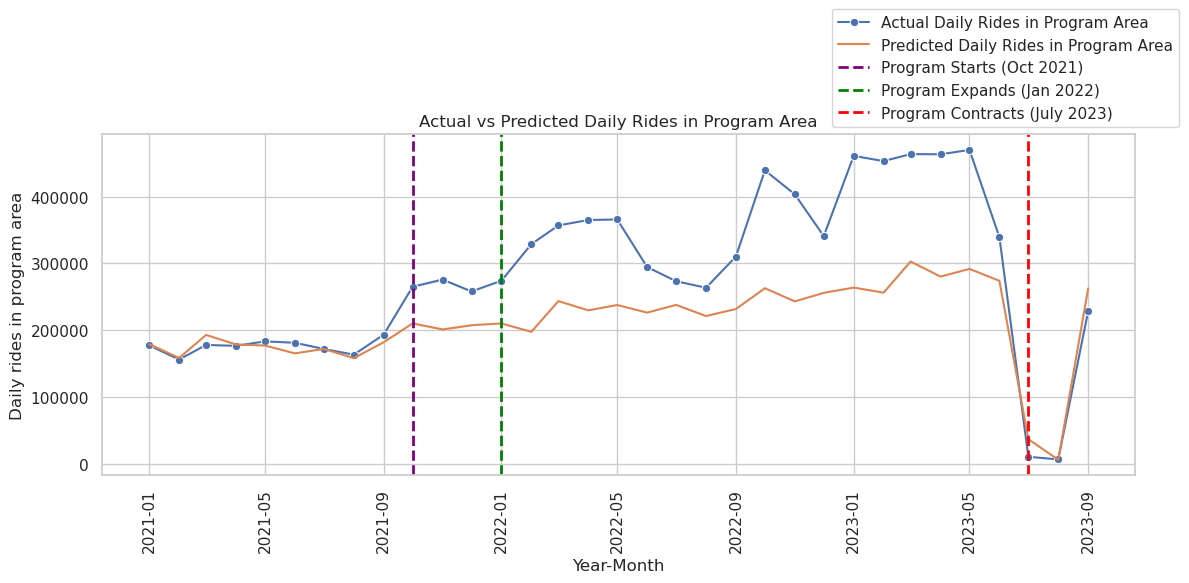

In [145]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='year_month', y='sum(area_sums)', data=final_dataset, marker='o', label='Actual Daily Rides in Program Area')
sns.lineplot(x='year_month', y='sum(prediction)', data=final_dataset, dashes=True, label='Predicted Daily Rides in Program Area')

plt.axvline(pd.to_datetime('2021-10-01'), color='purple', linestyle='--', linewidth=2, label='Program Starts (Oct 2021)')

plt.axvline(pd.to_datetime('2022-01-01'), color='green', linestyle='--', linewidth=2, label='Program Expands (Jan 2022)')


plt.axvline(pd.to_datetime('2023-07-01'), color='red', linestyle='--', linewidth=2, label='Program Contracts (July 2023)')
#plt.text(pd.to_datetime('2023-07-01'), final_dataset['sum(area_sums)'].max(), 'Program Contracts',
   #      rotation=0, verticalalignment='bottom', horizontalalignment='right', color='red')

plt.title('Actual vs Predicted Daily Rides in Program Area')
plt.xlabel('Year-Month')
plt.ylabel('Daily rides in program area')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc='lower right')
plt.tight_layout()
plt.show()

### Notes for Abe on work done:

- Added predicted pre-program trends based on pre-program data.
- Added predictions for after program expansion based on pre-program data.
- Made all the plots nicer using Seaborn
- Created a final plot for data from 2021-2023. 

## Abe Notes for harsh

Ok so I ran these models without cross validation and saved them to the models folder in GCS. We can do cross validation if you have time to debug and run. If you have to rerun any of my code, I would consider repartitioning because its still going through 600 partitions for the tiny datset we're working with. The plots could be improved by  putting in the pre-trends and giving them better titles and labels as well I just ran out of time to do that. It shouldn't take long to do that. Let me know if you're confused about anything I did. I think its possible this is good enough for a final product once the plots have pre-trends added and things are cleaned up. That could also give you more time to check on our groupmates if necessary haha. We're getting close.

# pseudocode if we want to do cross validation

In [ ]:
#taken from ashish's notebook- to check if we need to convert anything to labels
def labelForResults(s):
    if s == 'Fail':
        return 0.0
    elif s == 'Pass w/ Conditions' or s == 'Pass':
        return 1.0
    else:
        return -1.0
    
#add labels to the original dataset    
label = UserDefinedFunction(labelForResults, DoubleType())
labeledData = df.select(df.Violations,label(df.Results).alias('label')).where('label >= 0')
labeledData.show(10, truncate=False)

In [45]:
# an open question for me is that in Ashish's code and online examples, the model is fit and tested on the same full dataset. which is confusing to me
# I would think you would fit on training and transform the test set. Something to look into.

# look to adjust the parameters regparam and elastic net

paramGrid = ParamGridBuilder().addGrid(lr.regParam, [0.1, 0.01]).addGrid(
    lr.elasticNetParam, [0.2, 0.4,0.6, 0.8,1.0]).build() 
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=10) 

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(train_df)


23/11/25 03:43:39 WARN org.apache.spark.sql.execution.CacheManager: Asked to cache already cached data.
23/11/25 03:43:39 WARN org.apache.spark.sql.execution.CacheManager: Asked to cache already cached data.


IllegalArgumentException: label does not exist. Available: month, year, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, area_sums, temp, precip, snow, snowdepth, sunset, features, CrossValidator_82ced15f4dc7_rand, prediction

In [ ]:

# Save the model in a location so we don't have to rerun this
model_path = "gs://msca-bdp-student-gcs/bdp-rideshare-project/models/supervised_model/"
cvModel.write().save(model_path)

# Read the model back in
cvModelRead = CrossValidatorModel.read().load(model_path)

# Make predictions on test documents. cvModel uses the best model found (lrModel).
predictions = cvModel.transform(test_df)